In [1]:
from PIL import Image
from pynq import allocate, Overlay
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
image_file = 'original_image.png'

with Image.open('original_image.png') as img:
    IMAGE_WIDTH, IMAGE_HEIGHT = img.size

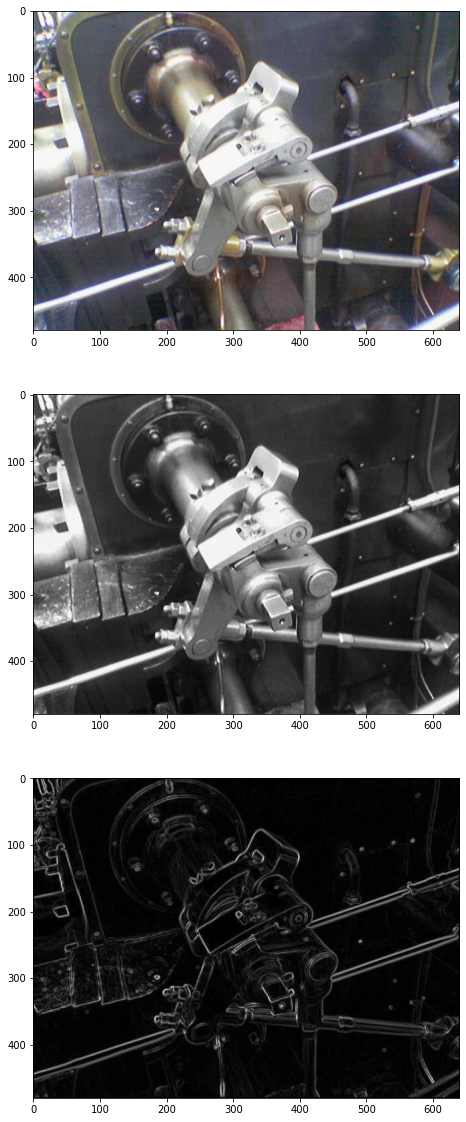

In [3]:
input_image = plt.imread(image_file)

r_img, g_img, b_img = input_image[:, :, 0], input_image[:, :, 1], input_image[:, :, 2]

gamma = 1.400
r_const, g_const, b_const = 0.2126, 0.7152, 0.0722
grayscale_image = r_const * r_img ** gamma + g_const * g_img ** gamma + b_const * b_img ** gamma

"""
     |                 |                 |                  |
     | 1.0   0.0  -1.0 |                 |  1.0   2.0   1.0 |
Gx = | 2.0   0.0  -2.0 |    and     Gy = |  0.0   0.0   0.0 |
     | 1.0   0.0  -1.0 |                 | -1.0  -2.0  -1.0 |
     |                 |                 |                  |
"""

Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])

[rows, columns] = np.shape(grayscale_image)
sobel_filtered_image = np.zeros(shape=(rows, columns))

for i in range(rows - 2):
    for j in range(columns - 2):
        gx = np.sum(np.multiply(Gx, grayscale_image[i:i + 3, j:j + 3]))
        gy = np.sum(np.multiply(Gy, grayscale_image[i:i + 3, j:j + 3]))
        sobel_filtered_image[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)

fig = plt.figure(figsize=(20, 20)) 
   
fig.add_subplot(3, 1, 1) 
plt.imshow(input_image) 
fig.add_subplot(3, 1, 2) 
plt.imshow(grayscale_image, cmap=plt.get_cmap('gray')) 
fig.add_subplot(3, 1, 3)  
plt.imshow(sobel_filtered_image, cmap=plt.get_cmap('gray'))
plt.show()

# plt.imsave('sobel_filtered_image.png', sobel_filtered_image, cmap=plt.get_cmap('gray'))


In [4]:
def convert_png_to_raw(jpg_path):
    
    img = Image.open(jpg_path)

    img_array = np.array(img)
    
    raw_rgb_data = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint32)
    
    raw_rgb_data = img_array[:, :, 0] + (img_array[:, :, 1] << 8) + (img_array[:, :, 2] << 16)

    return raw_rgb_data

def add_padding_to_array(array):
    
    padded_img_gray_array = np.pad(array, pad_width=1, mode='constant', constant_values=0)
    
    raw_gray_data = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint32)
    
    for j in range(IMAGE_HEIGHT):
        for i in range(IMAGE_WIDTH):
            raw_gray_data[j, i] = padded_img_gray_array[j, i] + (padded_img_gray_array[j+1, i] << 8) + (padded_img_gray_array[j+2, i] << 16)
    
    return raw_gray_data

In [5]:
rgb_to_grayscale_ov = Overlay("rgb_design_wrapper.xsa")

In [6]:
rgb_to_grayscale_ov?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff4420fdf0>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay rgb_design_wrapper.xsa. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchies as attributes in the
overlay. If no other d

In [7]:
dma = rgb_to_grayscale_ov.axi_dma_0

In [8]:
in_buffer = allocate(shape=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                           dtype=np.uint32, cacheable=1)
out_buffer = allocate(shape=(IMAGE_HEIGHT, IMAGE_WIDTH),
                            dtype=np.uint32, cacheable=1)

In [9]:
data_to_send = convert_png_to_raw('original_image.png')
in_buffer[:] = np.array(data_to_send)

In [10]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [11]:
run_kernel()
print(out_buffer)

[[ 0 29 29 ... 19 19 18]
 [18 30 30 ... 19 19 19]
 [18 31 29 ... 19 19 19]
 ...
 [24 37 38 ... 26 26 25]
 [24 37 40 ... 25 25 25]
 [24 37 42 ... 25 25 25]]


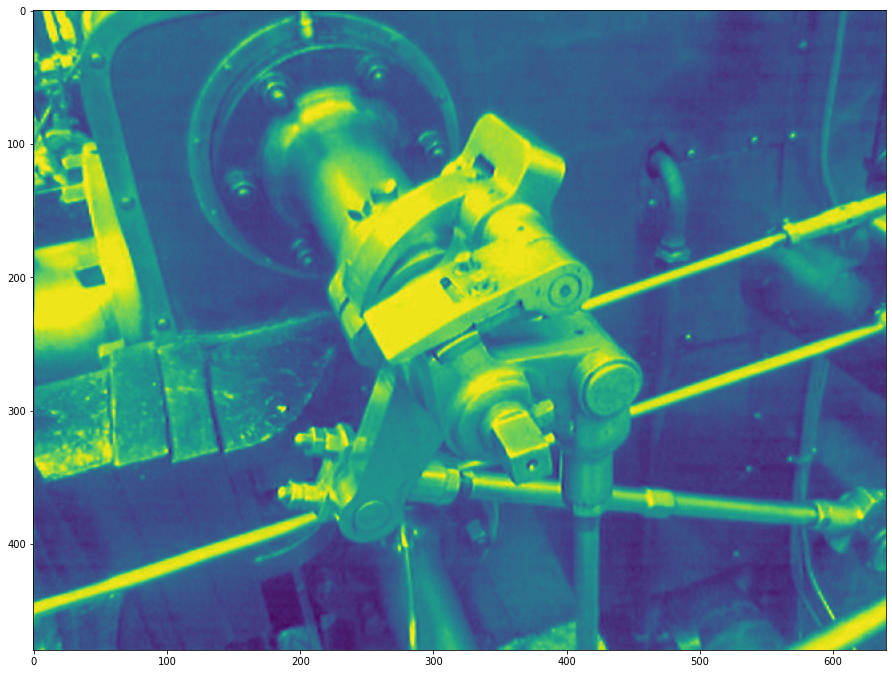

In [12]:
mode = 'L'  # 'L' - grayscale, 'RGB' - RGB
tablica_uint8 = out_buffer.astype(np.uint8)
img = Image.fromarray(tablica_uint8, mode=mode)
fig = plt.figure(figsize=(40, 40))
   
fig.add_subplot(3, 1, 1)
plt.imshow(img)
img.save('output_file.png', 'PNG')

In [13]:
gray_image_data = out_buffer.copy() #copy data to used it later in sobel filter

In [14]:
del in_buffer
del out_buffer

In [15]:
sobel_filter_ov = Overlay("sobel_design_wrapper.xsa")

In [16]:
sobel_filter_ov?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff37c50df0>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay sobel_design_wrapper.xsa. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchies as attributes in the
overlay. If no other

In [17]:
dma = sobel_filter_ov.axi_dma_0

In [18]:
in_buffer = allocate(shape=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                           dtype=np.uint32, cacheable=1)
out_buffer = allocate(shape=(IMAGE_HEIGHT, IMAGE_WIDTH),
                            dtype=np.uint32, cacheable=1)

In [19]:
data_to_send = add_padding_to_array(gray_image_data)
in_buffer[:] = np.array(data_to_send)

In [20]:
run_kernel()
print(out_buffer)

[[  0   0   0 ... 185 173 157]
 [153 163  48 ... 128 130   0]
 [  0 129   0 ...   0   1   0]
 ...
 [  0   0   0 ...   0   0   1]
 [  1   0 128 ...   0 128   0]
 [  1   0   0 ... 178 166  38]]


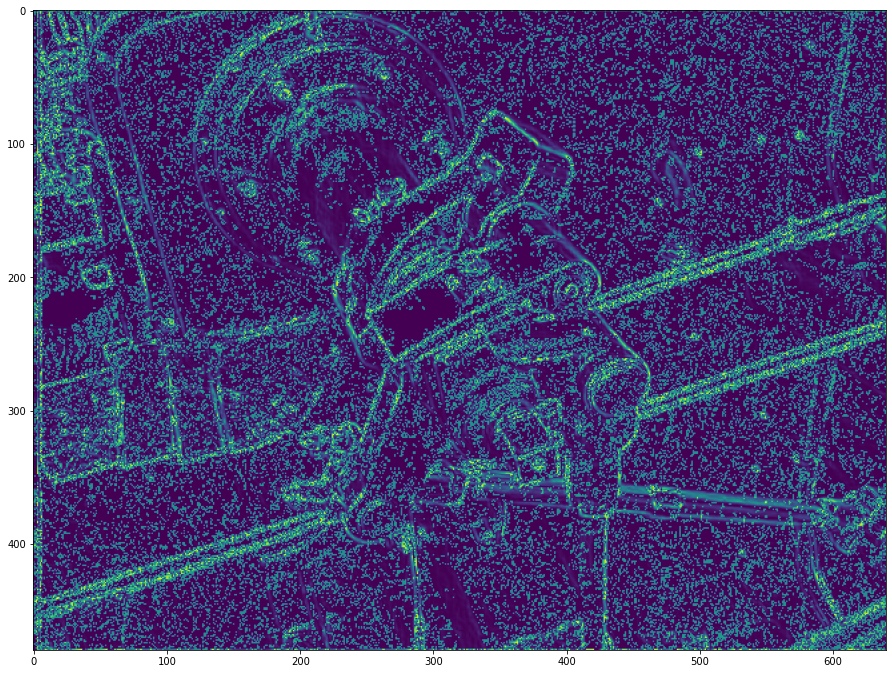

In [21]:
mode = 'L'  # 'L' - grayscale
tablica_uint8 = out_buffer.astype(np.uint8)
img = Image.fromarray(tablica_uint8, mode=mode)
fig = plt.figure(figsize=(40, 40))
   
fig.add_subplot(3, 1, 1)
plt.imshow(img)
img.save('output_file.png', 'PNG')

In [22]:
del in_buffer
del out_buffer